In [1]:
import pandas as pd
import numpy as np

import plotly.offline as pyo
import plotly.graph_objs as go

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
googleSheetId = '1rOvejFB9yC9rSQdQbIzpC_VFKj9GcCDA6mOSFnZl_aQ'
worksheetName = 'peoplecounts'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId,
    worksheetName
)

historical_data = pd.read_csv(URL)

In [3]:
historical_data

,Date,Price,count
0,1/2/2019,54.91,40
1,1/3/2019,55.95,40
2,1/4/2019,57.06,41
3,1/7/2019,57.33,41
4,1/8/2019,58.72,42
...,...,...,...
612,5/10/2021,60.19,53
613,5/11/2021,59.70,55
614,5/12/2021,59.21,52
615,5/13/2021,58.72,51


In [4]:

# Set Date column to datetime for time series
historical_data['Date'] = pd.to_datetime(historical_data['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data = historical_data.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data = historical_data.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data = historical_data.drop(columns=['Price'])

# Setting the Date as the index
historical_data = historical_data.set_index('Date')

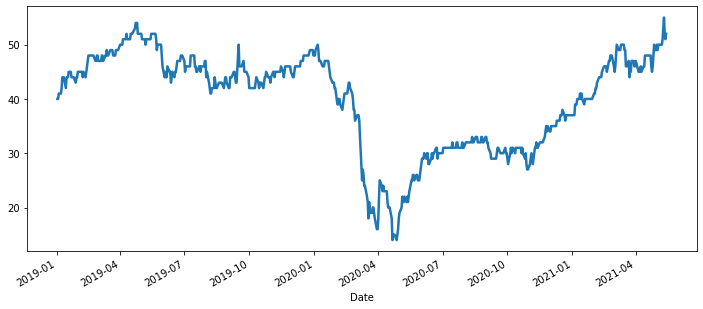

In [5]:
historical_data['count'].plot(lw=2.5, figsize=(12,5));

In [6]:
# Grabbing data from 2019-01-01
df = historical_data.loc['2019-01-01':]

In [7]:
##### evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=60.060
ARIMA(0, 0, 1) MSE=17.768
ARIMA(0, 1, 0) MSE=0.897
ARIMA(0, 1, 1) MSE=0.896
ARIMA(0, 1, 2) MSE=0.897
ARIMA(0, 1, 3) MSE=0.898
ARIMA(0, 2, 0) MSE=1.966
ARIMA(0, 2, 1) MSE=0.901
ARIMA(0, 2, 2) MSE=0.901
ARIMA(0, 2, 3) MSE=0.901
ARIMA(1, 0, 0) MSE=0.896
ARIMA(1, 0, 1) MSE=0.897
ARIMA(1, 0, 2) MSE=0.898
ARIMA(1, 0, 3) MSE=0.900
ARIMA(1, 1, 0) MSE=0.896
ARIMA(1, 2, 0) MSE=1.458
ARIMA(1, 2, 1) MSE=0.905
ARIMA(1, 2, 2) MSE=0.906
ARIMA(1, 2, 3) MSE=0.907
ARIMA(2, 0, 0) MSE=0.897
ARIMA(2, 1, 0) MSE=0.897
ARIMA(2, 2, 0) MSE=1.284
ARIMA(2, 2, 1) MSE=0.901
ARIMA(2, 2, 2) MSE=0.903
ARIMA(2, 2, 3) MSE=0.930
ARIMA(3, 0, 0) MSE=0.898
ARIMA(3, 0, 1) MSE=0.913
ARIMA(3, 0, 2) MSE=0.910
ARIMA(3, 0, 3) MSE=0.916
ARIMA(3, 1, 0) MSE=0.898
ARIMA(3, 2, 0) MSE=1.194
ARIMA(3, 2, 1) MSE=0.906
ARIMA(3, 2, 2) MSE=0.910
ARIMA(3, 2, 3) MSE=0.914
Best ARIMA(0, 1, 1) MSE=0.896


In [8]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 365 days/year.
model = sm.tsa.statespace.SARIMAX(historical_data['count'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 365),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results = model.fit()

Wall time: 9min 58s


In [33]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions = round(SARIMAX_results.predict(), 0)

# Creating a dataframe of the date index and predictions
SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','Predictedcount']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df = pd.merge(historical_data[1:], SARIMAX_preds, left_index=True, right_index=True)

SARIMAX_predicted_df.head()

,count,Predictedcount
Date,,
2019-01-03,40,40.0
2019-01-04,41,40.0
2019-01-07,41,41.0
2019-01-08,42,41.0
2019-01-09,44,42.0


In [34]:
print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['count'], 
                                                  SARIMAX_predicted_df['Predictedcount']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['count'], 
                                                               SARIMAX_predicted_df['Predictedcount'])))

	Mean Squared Error: 1.1574675324675325
	Root Mean Squared Error: 1.07585665051973


In [35]:
# Getting 6 months for forecasts
SARIMAX_forecast = round(SARIMAX_results.forecast(steps = 120), 0)


In [36]:
SARIMAX_forecast

617    52.0
618    52.0
619    52.0
620    52.0
621    52.0
       ... 
732    48.0
733    48.0
734    48.0
735    48.0
736    48.0
Length: 120, dtype: float64

In [37]:

idx = pd.date_range('2021-05-13', '2021-10-01', freq='B')

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                             columns=['Date','ForecastCount']).set_index('Date')

SARIMAX_forecast.head()

,ForecastCount
Date,
2021-05-13,52.0
2021-05-14,52.0
2021-05-17,52.0
2021-05-18,52.0
2021-05-19,52.0


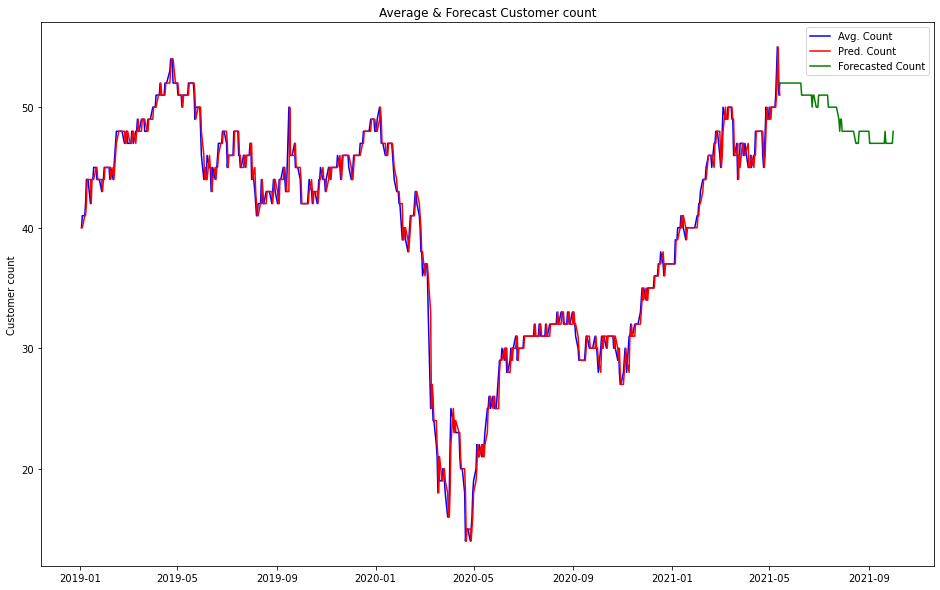

In [38]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['count'],c='b',label='Avg. Count')
ax.plot(SARIMAX_predicted_df['Predictedcount'],c='r', label='Pred. Count')
ax.plot(SARIMAX_forecast['ForecastCount'],c='g', label='Forecasted Count')

plt.legend(loc='best')
plt.ylabel('Customer count')
plt.title('Average & Forecast Customer count')
plt.draw()

In [39]:
trace0 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['count'],
    mode = 'lines',
    name = 'Daily count'
)
trace1 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Predictedcount'],
    mode = 'lines',
    name = 'Predicted count'
)
trace2 = go.Scatter(
    x = SARIMAX_forecast.index,
    y = SARIMAX_forecast['ForecastCount'],
    mode = 'lines',
    name = 'Forecast count'
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'SARIMAX Model: Daily & 6-Month Forecast Person Count',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'count)')
) 

fig1 = go.Figure(data = data, layout = layout)

pyo.plot(fig1)

'temp-plot.html'

=================================================================================

In [16]:
googleSheetId = '1MBWHr0e5uE6wVRzmgx1kf4AFRhemANHqj_nmnHiKLOM'
worksheetName = 'Sanitizer'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId,
    worksheetName
)

historical_volume = pd.read_csv(URL)

In [17]:

# Set Date column to datetime for time series
historical_volume['Date'] = pd.to_datetime(historical_volume['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_volume = historical_volume.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_volume = historical_volume.reset_index(drop = True)

# Dropping all columns except for the Closing Price
#historical_data = historical_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

# Setting the Date as the index
historical_volume = historical_volume.set_index('Date')

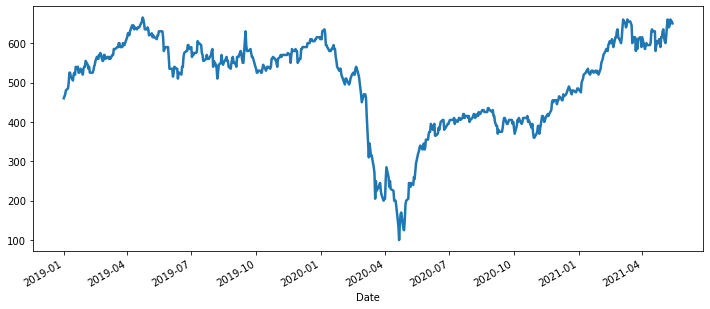

In [18]:
# Simple plot of historical data
historical_volume['volume'].plot(lw=2.5, figsize=(12,5));

In [19]:
# Grabbing data from 2018-01-01
df1 = historical_volume.loc['2019-01-01':]

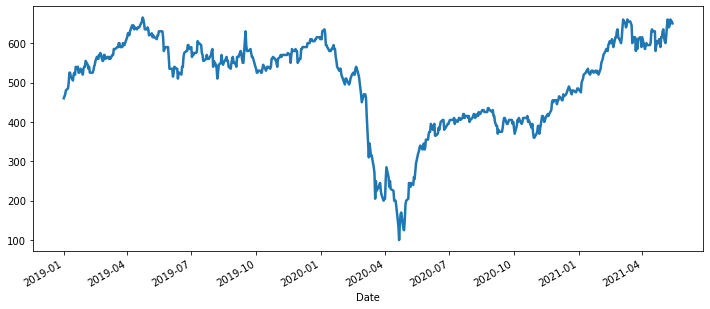

In [20]:
# Simple plot of data from January 2016
df1['volume'].plot(lw=2.5, figsize=(12,5));

In [21]:
##### evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(df1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=9077.515
ARIMA(0, 0, 1) MSE=2619.670
ARIMA(0, 1, 0) MSE=142.925
ARIMA(0, 1, 1) MSE=143.478
ARIMA(0, 1, 2) MSE=143.298
ARIMA(0, 1, 3) MSE=144.448
ARIMA(0, 2, 0) MSE=319.539
ARIMA(0, 2, 1) MSE=144.770
ARIMA(0, 2, 2) MSE=145.617
ARIMA(0, 2, 3) MSE=145.000
ARIMA(1, 0, 0) MSE=143.270
ARIMA(1, 0, 1) MSE=143.952
ARIMA(1, 0, 2) MSE=143.861
ARIMA(1, 0, 3) MSE=144.985
ARIMA(1, 1, 0) MSE=143.459
ARIMA(1, 2, 0) MSE=231.429
ARIMA(1, 2, 1) MSE=145.603
ARIMA(1, 2, 2) MSE=144.379
ARIMA(2, 0, 0) MSE=143.933
ARIMA(2, 0, 3) MSE=145.431
ARIMA(2, 1, 0) MSE=143.395
ARIMA(2, 2, 0) MSE=198.795
ARIMA(2, 2, 1) MSE=145.120
ARIMA(3, 0, 0) MSE=143.927
ARIMA(3, 0, 3) MSE=145.083
ARIMA(3, 1, 0) MSE=144.134
ARIMA(3, 2, 0) MSE=198.146
ARIMA(3, 2, 1) MSE=146.378
ARIMA(3, 2, 2) MSE=145.847
Best ARIMA(0, 1, 0) MSE=142.925


In [28]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 365 days/year.
volume_model = sm.tsa.statespace.SARIMAX(df1['volume'],
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 365),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results_volume = volume_model.fit()

Wall time: 10min 30s


In [29]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions_volume = round(SARIMAX_results_volume.predict(), 2)

# Creating a dataframe of the date index and predictions
SARIMAX_preds_volume = pd.DataFrame(list(zip(list(SARIMAX_predictions_volume.index),list(SARIMAX_predictions_volume))),
                             columns=['Date','Predictedvolume']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df_volume = pd.merge(df1[1:], SARIMAX_preds_volume, left_index=True, right_index=True)

SARIMAX_predicted_df_volume.head()

,volume,Predictedvolume
Date,,
2019-01-02,465,460.0
2019-01-03,470,465.0
2019-01-04,480,470.0
2019-01-07,485,480.0
2019-01-08,500,485.0


In [30]:
# Getting 120 days (a little more than 6 months in business days) for forecasts
SARIMAX_forecast_volume = round(SARIMAX_results_volume.forecast(steps = 120), 2)

# Creating an index from 2021-04-19 to six months out, frequency indicates business day which eliminates weekends and
# US holidays, then putting it all together into a SARIMAX_forecast dataframe
idx = pd.date_range('2021-05-13', '2021-10-01', freq='B')

SARIMAX_forecast_df_volume = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast_volume))),
                             columns=['Date','Forecastvolume']).set_index('Date')

SARIMAX_forecast_df_volume.head()

,Forecastvolume
Date,
2021-05-13,645.0
2021-05-14,665.0
2021-05-17,670.0
2021-05-18,660.0
2021-05-19,630.0


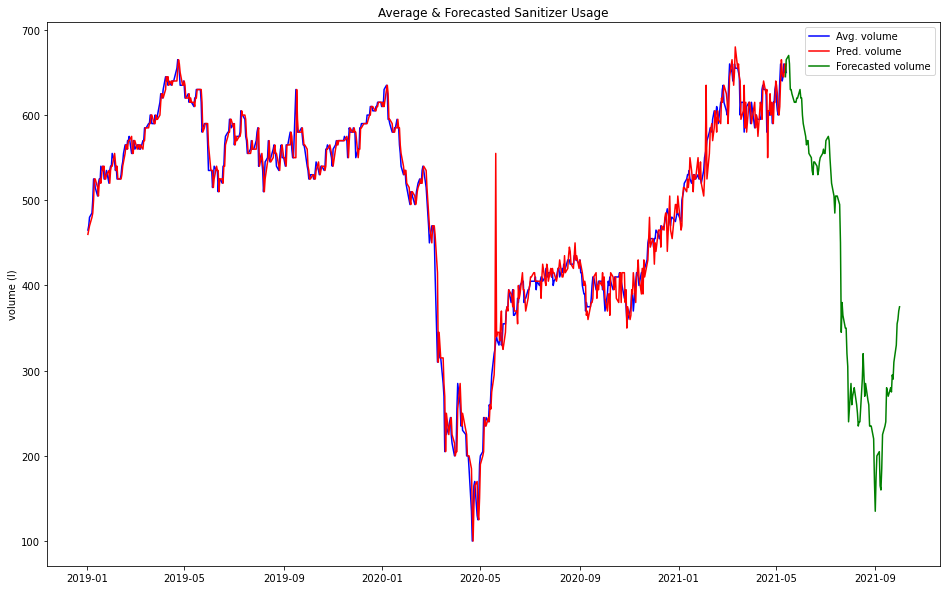

In [31]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df_volume['volume'],c='b',label='Avg. volume')
ax.plot(SARIMAX_predicted_df_volume['Predictedvolume'],c='r', label='Pred. volume')
ax.plot(SARIMAX_forecast_df_volume['Forecastvolume'],c='g', label='Forecasted volume')

plt.legend(loc='best')
plt.ylabel('volume (l)')
plt.title('Average & Forecasted Sanitizer Usage')
plt.draw()

In [41]:
#Plotly Code for Blog Post
trace01 = go.Scatter(
    x = SARIMAX_predicted_df_volume.index,
    y = SARIMAX_predicted_df_volume['volume'],
    mode = 'lines',
    name = 'Daily Sanitizer Usage'
)
trace11 = go.Scatter(
    x = SARIMAX_predicted_df_volume.index,
    y = SARIMAX_predicted_df_volume['Predictedvolume'],
    mode = 'lines',
    name = 'Predicted Sanitizer Usage'
)
trace21 = go.Scatter(
    x = SARIMAX_forecast_df_volume.index,
    y = SARIMAX_forecast_df_volume['Forecastvolume'],
    mode = 'lines',
    name = 'Forecast Sanitizer Usage'
)
data_volume = [trace01, trace11, trace21]

Volumelayout = go.Layout(
    title = 'SARIMAX Model: Daily & 6-Month Forecast Sanitizer Usage',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = ' Sanitizer Usage (ml)')
) 

Volumefig = go.Figure(data = data_volume, layout = Volumelayout)
#fig = go.Figure(data = data, layout = layout)
pyo.plot(Volumefig)

'temp-plot.html'

In [42]:
def figures_to_html(figs, filename="New_SanitizerFinal.html"):
    dashboard = open(filename, 'w')
    dashboard.write("<html><head></head><body>" + "\n")
    for fig in figs:
        inner_html = fig.to_html().split('<body>')[1].split('</body>')[0]
        dashboard.write(inner_html)
    dashboard.write("</body></html>" + "\n")


# Example figures


figures_to_html([fig1, Volumefig])
